# Análisis del Dataset IRIS con k-NN

## Objetivo
Aplicar el algoritmo k-vecinos más cercanos (k-NN) al conjunto de datos IRIS para clasificar especies de flores, incluyendo análisis exploratorio, preprocesamiento, entrenamiento y evaluación del modelo.

## Importar librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
import os
warnings.filterwarnings('ignore')

# Crear directorio de salida si no existe
os.makedirs('out', exist_ok=True)

# Configurar estilo de gráficos
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Cargar y revisar el dataset IRIS

In [2]:
# Cargar el dataset IRIS
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target
df['species_name'] = df['species'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

print("Dimensiones del dataset:", df.shape)
print("\nPrimeras 5 filas:")
df.head()

Dimensiones del dataset: (150, 6)

Primeras 5 filas:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [3]:
# Información general del dataset
print("Información del dataset:")
print(df.info())
print("\nEstadísticas descriptivas:")
df.describe()

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
 5   species_name       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB
None

Estadísticas descriptivas:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [4]:
# Verificar valores nulos y distribución de especies
print("Valores nulos por columna:")
print(df.isnull().sum())
print("\nDistribución de especies:")
print(df['species_name'].value_counts())

Valores nulos por columna:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
species_name         0
dtype: int64

Distribución de especies:
species_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


## 2. Análisis exploratorio visual

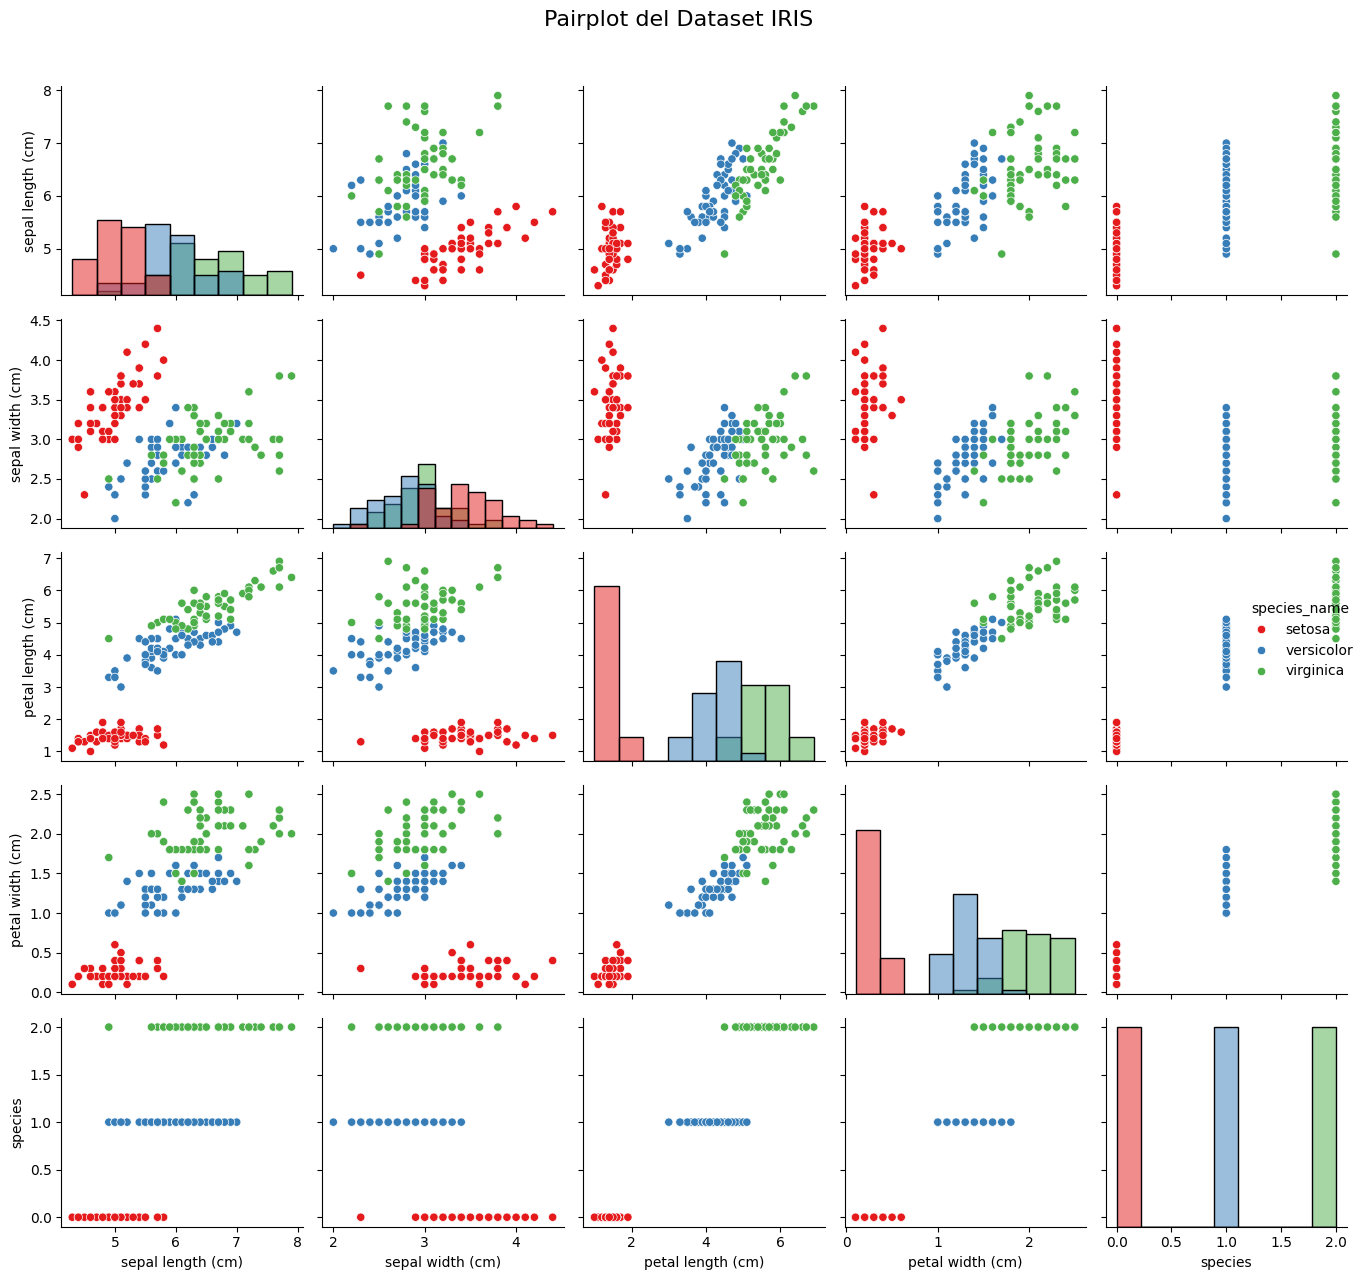

In [5]:
# Pairplot para visualizar relaciones entre todas las variables
g = sns.pairplot(df, hue='species_name', palette='Set1', diag_kind='hist')
g.fig.suptitle('Pairplot del Dataset IRIS', y=1.02, fontsize=16)
plt.tight_layout()
g.savefig('out/pairplot_iris.png', dpi=300, bbox_inches='tight')
plt.show()

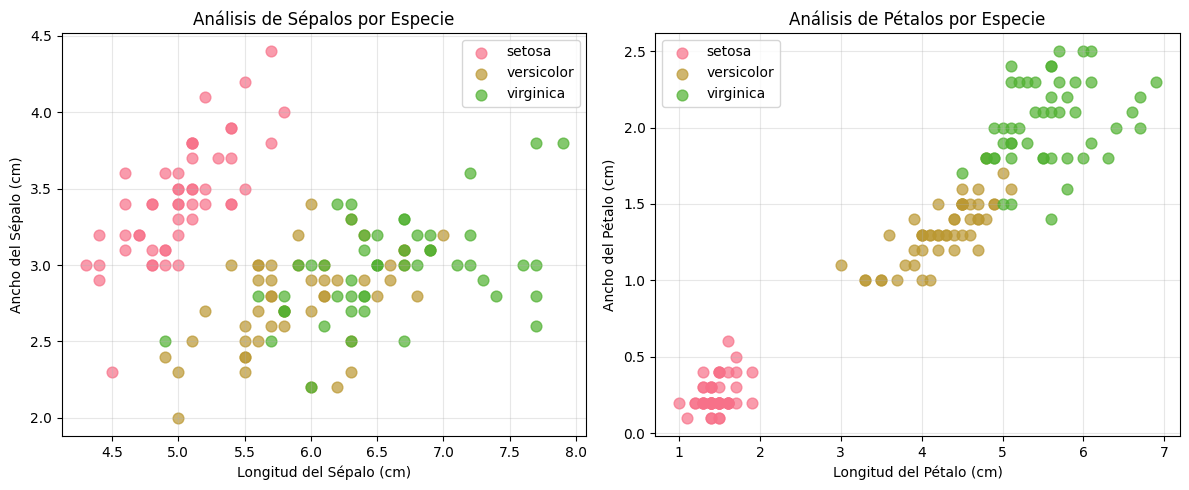

In [6]:
# Gráfico de dispersión para sépalos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for species in df['species_name'].unique():
    species_data = df[df['species_name'] == species]
    plt.scatter(species_data['sepal length (cm)'], species_data['sepal width (cm)'], 
               label=species, alpha=0.7, s=60)
plt.xlabel('Longitud del Sépalo (cm)')
plt.ylabel('Ancho del Sépalo (cm)')
plt.title('Análisis de Sépalos por Especie')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de dispersión para pétalos
plt.subplot(1, 2, 2)
for species in df['species_name'].unique():
    species_data = df[df['species_name'] == species]
    plt.scatter(species_data['petal length (cm)'], species_data['petal width (cm)'], 
               label=species, alpha=0.7, s=60)
plt.xlabel('Longitud del Pétalo (cm)')
plt.ylabel('Ancho del Pétalo (cm)')
plt.title('Análisis de Pétalos por Especie')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('out/analisis_sepalos_petalos.png', dpi=300, bbox_inches='tight')
plt.show()

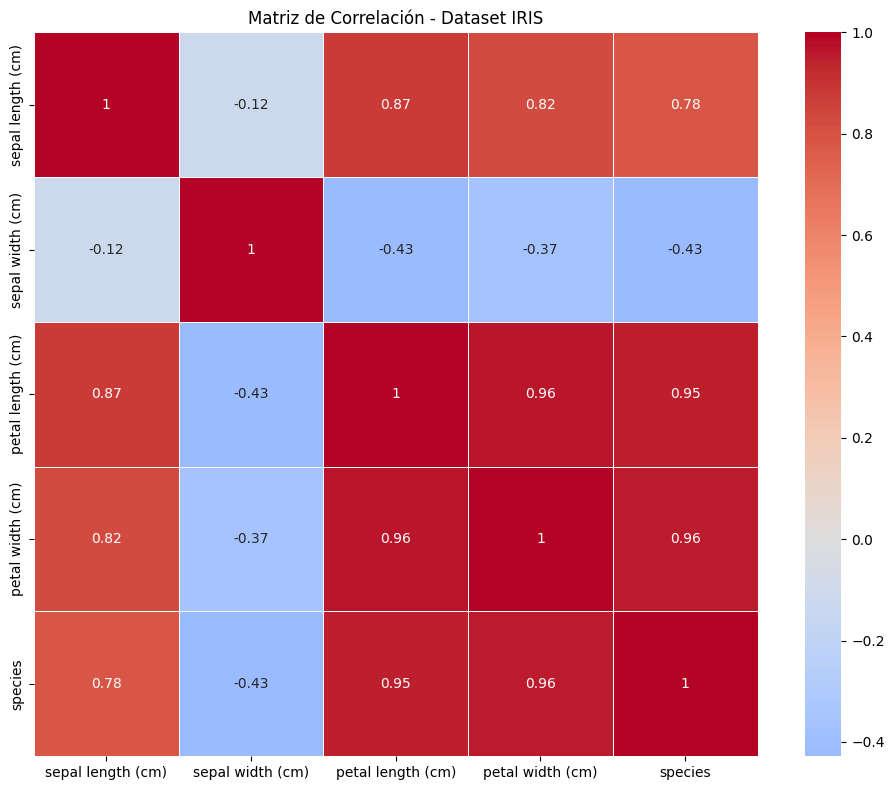

In [7]:
# Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Matriz de Correlación - Dataset IRIS')
plt.tight_layout()
plt.savefig('out/matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Preprocesamiento de datos

In [8]:
# Separar características (X) y variable objetivo (y)
X = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]
y = df['species']

print("Forma de X (características):", X.shape)
print("Forma de y (objetivo):", y.shape)
print("\nPrimeras 5 filas de X:")
print(X.head())
print("\nPrimeras 5 valores de y:")
print(y.head())

Forma de X (características): (150, 4)
Forma de y (objetivo): (150,)

Primeras 5 filas de X:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Primeras 5 valores de y:
0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int64


In [9]:
# División de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Tamaño del conjunto de entrenamiento:", X_train.shape[0])
print("Tamaño del conjunto de prueba:", X_test.shape[0])
print("\nDistribución en entrenamiento:")
print(pd.Series(y_train).value_counts().sort_index())
print("\nDistribución en prueba:")
print(pd.Series(y_test).value_counts().sort_index())

Tamaño del conjunto de entrenamiento: 105
Tamaño del conjunto de prueba: 45

Distribución en entrenamiento:
species
0    35
1    35
2    35
Name: count, dtype: int64

Distribución en prueba:
species
0    15
1    15
2    15
Name: count, dtype: int64


In [10]:
# Normalización de datos (opcional para k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Estadísticas de X_train original:")
print(pd.DataFrame(X_train).describe())
print("\nEstadísticas de X_train normalizado:")
print(pd.DataFrame(X_train_scaled, columns=X.columns).describe())

Estadísticas de X_train original:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         105.000000        105.000000         105.000000   
mean            5.873333          3.055238           3.784762   
std             0.862941          0.457203           1.784052   
min             4.300000          2.000000           1.100000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.200000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        105.000000  
mean           1.205714  
std            0.777549  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.900000  
max            2.500000  

Estadísticas de X_train normalizado:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count       1.050000e+02      1.050000e+02 

## 4. Implementación del modelo k-NN

In [11]:
# Entrenar modelo k-NN con k=5
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = knn.predict(X_test_scaled)

print(f"Modelo k-NN entrenado con k={k}")
print(f"Predicciones realizadas: {len(y_pred)}")

Modelo k-NN entrenado con k=5
Predicciones realizadas: 45


## 5. Evaluación del modelo

In [12]:
# Calcular precisión
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Reporte de clasificación detallado
print("\nReporte de clasificación:")
target_names = ['setosa', 'versicolor', 'virginica']
print(classification_report(y_test, y_pred, target_names=target_names))

Precisión del modelo: 0.9111 (91.11%)

Reporte de clasificación:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.79      1.00      0.88        15
   virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



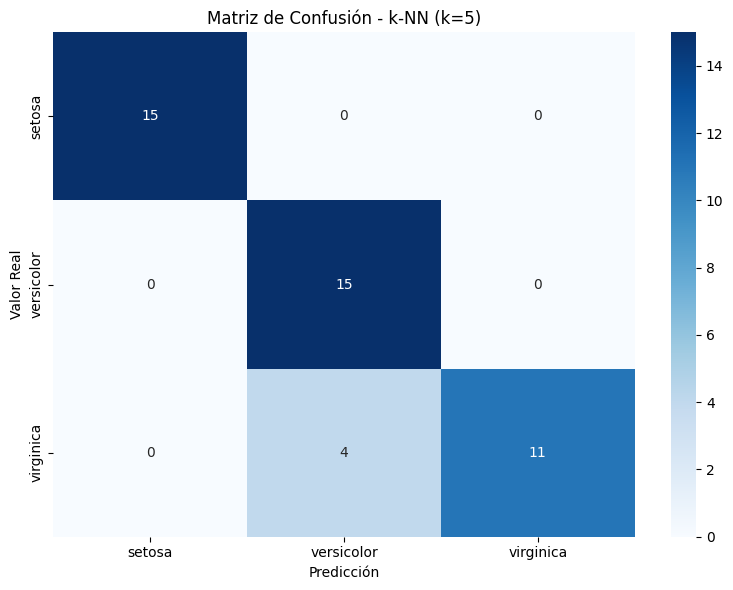


Matriz de confusión:
            setosa  versicolor  virginica
setosa          15           0          0
versicolor       0          15          0
virginica        0           4         11


In [13]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusión - k-NN (k=5)')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.tight_layout()
plt.savefig('out/matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMatriz de confusión:")
print(pd.DataFrame(cm, index=target_names, columns=target_names))

## 6. Optimización del valor de k

In [14]:
# Probar diferentes valores de k
k_values = range(1, 21)
accuracies = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred_temp))

# Encontrar el mejor k
best_k = k_values[np.argmax(accuracies)]
best_accuracy = max(accuracies)

print(f"Mejor valor de k: {best_k}")
print(f"Mejor precisión: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

Mejor valor de k: 9
Mejor precisión: 0.9556 (95.56%)


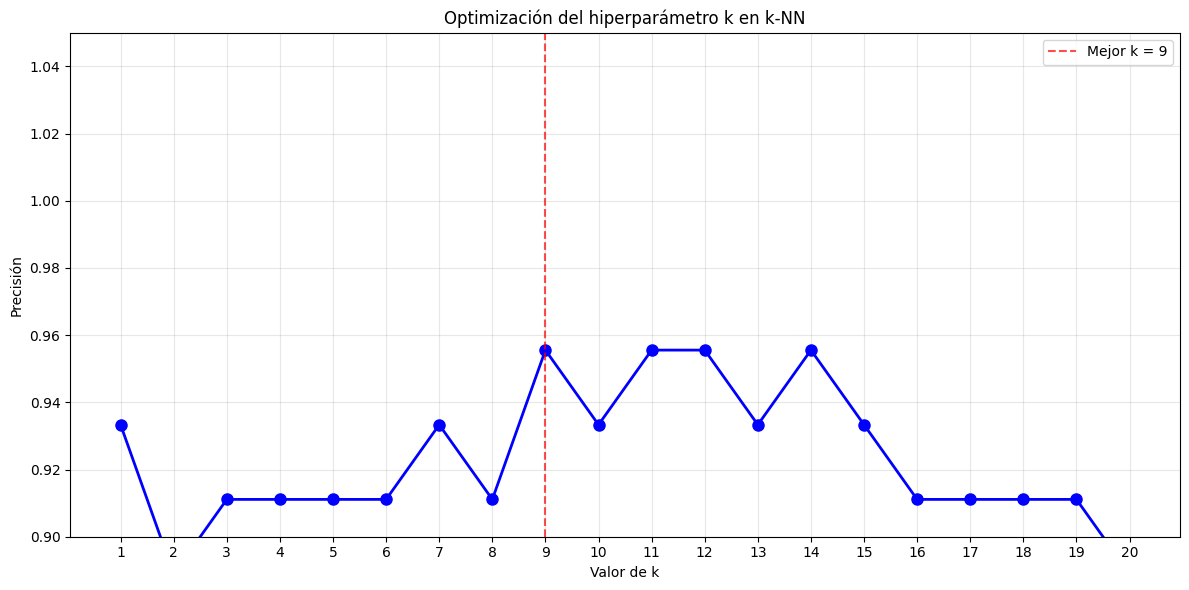

In [15]:
# Visualizar el rendimiento para diferentes valores de k
plt.figure(figsize=(12, 6))
plt.plot(k_values, accuracies, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'Mejor k = {best_k}')
plt.xlabel('Valor de k')
plt.ylabel('Precisión')
plt.title('Optimización del hiperparámetro k en k-NN')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_values)
plt.ylim(0.9, 1.05)
plt.tight_layout()
plt.savefig('out/optimizacion_k.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Análisis de resultados y conclusiones

In [16]:
# Entrenar modelo final con el mejor k
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)
y_pred_final = knn_final.predict(X_test_scaled)

print("=== RESULTADOS FINALES ===")
print(f"Modelo final: k-NN con k={best_k}")
print(f"Precisión final: {accuracy_score(y_test, y_pred_final):.4f}")
print("\nComparación de predicciones vs valores reales:")
comparison_df = pd.DataFrame({
    'Real': [target_names[i] for i in y_test],
    'Predicción': [target_names[i] for i in y_pred_final]
})
comparison_df['Correcto'] = comparison_df['Real'] == comparison_df['Predicción']
print(comparison_df.head(10))
print(f"\nAciertos: {comparison_df['Correcto'].sum()}/{len(comparison_df)}")

=== RESULTADOS FINALES ===
Modelo final: k-NN con k=9
Precisión final: 0.9556

Comparación de predicciones vs valores reales:
         Real  Predicción  Correcto
0   virginica   virginica      True
1  versicolor  versicolor      True
2   virginica  versicolor     False
3  versicolor  versicolor      True
4   virginica   virginica      True
5   virginica   virginica      True
6  versicolor  versicolor      True
7  versicolor  versicolor      True
8      setosa      setosa      True
9   virginica   virginica      True

Aciertos: 43/45


In [17]:
# Análisis de características más importantes
feature_names = ['Longitud Sépalo', 'Ancho Sépalo', 'Longitud Pétalo', 'Ancho Pétalo']
print("=== ANÁLISIS DE CARACTERÍSTICAS ===")
print("\nEstadísticas por especie:")
for i, species in enumerate(target_names):
    species_data = df[df['species'] == i]
    print(f"\n{species.upper()}:")
    for j, feature in enumerate(feature_names):
        mean_val = species_data.iloc[:, j].mean()
        std_val = species_data.iloc[:, j].std()
        print(f"  {feature}: {mean_val:.2f} ± {std_val:.2f}")

=== ANÁLISIS DE CARACTERÍSTICAS ===

Estadísticas por especie:

SETOSA:
  Longitud Sépalo: 5.01 ± 0.35
  Ancho Sépalo: 3.43 ± 0.38
  Longitud Pétalo: 1.46 ± 0.17
  Ancho Pétalo: 0.25 ± 0.11

VERSICOLOR:
  Longitud Sépalo: 5.94 ± 0.52
  Ancho Sépalo: 2.77 ± 0.31
  Longitud Pétalo: 4.26 ± 0.47
  Ancho Pétalo: 1.33 ± 0.20

VIRGINICA:
  Longitud Sépalo: 6.59 ± 0.64
  Ancho Sépalo: 2.97 ± 0.32
  Longitud Pétalo: 5.55 ± 0.55
  Ancho Pétalo: 2.03 ± 0.27
